## ASEAN Countries CO₂ Emission Forecast

Objectives
- Implement Polynomial Regression to quantify historical CO₂ emission trends and evaluate model robustness using **R²** and **RMSE performance metrics**.
- Develop a forecasting framework to project CO₂ emissions per capita up to 2045 across all ASEAN member states.
- Construct comprehensive visual analyses illustrating both historical patterns and projected trajectories of ASEAN CO₂ emissions per capita.
- Integrate Polynomial Regression and Prophet forecasting to enhance long-term prediction reliability and capture nonlinear temporal dynamics within regional emission trends.

Data Sources: Global Carbon Budget (2024)Population based on various sources (2024) – with major processing by Our World in Data

In [30]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

plt.style.use("seaborn-v0_8-whitegrid")


In [32]:
# Load dataset
df = pd.read_csv("co2_emission_asean_clean.csv")
df.head()


,country,year,co2_per_capita
0,Brunei,1933,0.106975
1,Brunei,1934,1.244213
2,Brunei,1935,0.703475
3,Brunei,1936,2.045512
4,Brunei,1937,5.286885


## 1. Selecting the Best Polynomial Regression Model

To accurately model each country's CO₂ emission trends, we use **Polynomial Regression** — a technique that captures nonlinear relationships between year and CO₂ emissions per capita.

This function `fit_best_polynomial()` automatically tests polynomial degrees from 1 up to a defined limit (default: 5) and evaluates each model’s performance using **R²** and **RMSE** metrics.  
The model with the highest R² score is selected as the best fit for the dataset.


In [33]:
# Fit the best polynominal regression model
def fit_best_polynomial(X, y, max_degree=5):
    results = []
    best_model = None
    best_degree = None
    best_r2 = -np.inf
    
    for degree in range(1, max_degree + 1):
        poly = PolynomialFeatures(degree=degree)
        X_poly = poly.fit_transform(X)
        
        model = LinearRegression().fit(X_poly, y)
        y_pred = model.predict(X_poly)
        
        r2 = r2_score(y, y_pred)
        rmse = np.sqrt(mean_squared_error(y, y_pred))
        
        results.append((degree, r2, rmse))
        
        if r2 > best_r2:
            best_r2 = r2
            best_model = model
            best_degree = degree
            best_poly = poly
            
    return best_model, best_poly, best_degree, results


In [34]:
# Model fitting and evaluation
country = "Indonesia"
c_df = df[df["country"] == country].dropna(subset=["co2_per_capita"])

X = c_df["year"].values.reshape(-1, 1)
y = c_df["co2_per_capita"].values

model, poly, best_degree, results = fit_best_polynomial(X, y, max_degree=5)

print(f"Best degree for {country}: {best_degree}")
pd.DataFrame(results, columns=["Degree", "R2", "RMSE"])


Best degree for Indonesia: 3


,Degree,R2,RMSE
0,1,0.728127,0.350583
1,2,0.933704,0.173122
2,3,0.979234,0.096891
3,4,0.979049,0.097323
4,5,0.978849,0.097784


## 2. Forecast Generation

After identifying the best polynomial model for each country, we project future CO₂ emissions per capita up to the year **2045**.  
Using the trained polynomial regression model, we generate predictions (`future_pred`) based on future year values (`future_years`) and store the results in a new dataframe `forecast_df`.


In [35]:
# Forecast generation 
future_years = np.arange(df["year"].max() + 1, 2045).reshape(-1, 1)
future_poly = poly.transform(future_years)
future_pred = model.predict(future_poly)

forecast_df = pd.DataFrame({
    "Year": future_years.flatten(),
    "Predicted_CO2_per_capita": future_pred
})


In [36]:
# Model evaluation (on historical data only)
y_pred = model.predict(poly.transform(X))  
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

print(f"{country} — Polynomial Degree {best_degree}")
print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")


Indonesia — Polynomial Degree 3
R² Score: 0.979
RMSE: 0.097


## 3. Trend and Forecast Visualization


In [37]:
# Predict next 20 years
future_years = np.arange(df["year"].max() + 1, 2045).reshape(-1, 1)
future_poly = poly.transform(future_years)
future_pred = model.predict(future_poly)

forecast_df = pd.DataFrame({
    "year": future_years.flatten(),     
    "Predicted_CO2_per_capita": future_pred
})


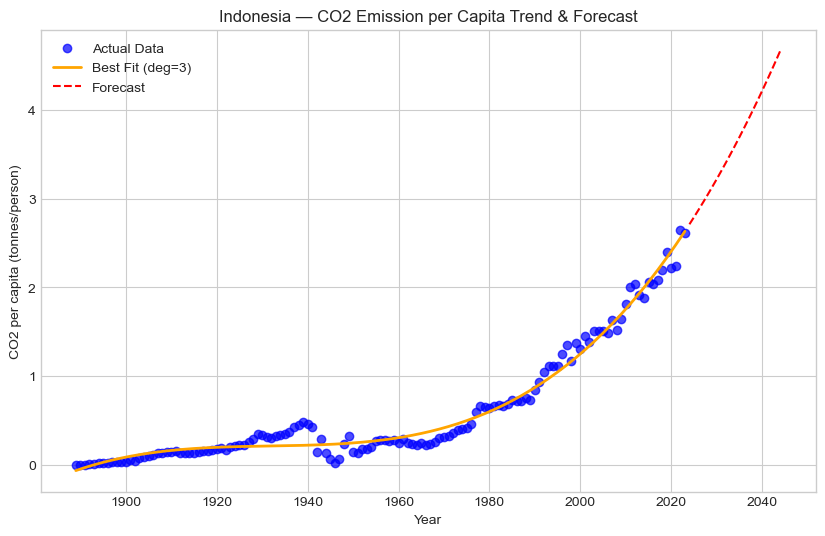

In [ ]:
# historical years for visualization
y_pred = model.predict(poly.transform(X))

plt.figure(figsize=(10,6))
plt.scatter(X, y, color="blue", alpha=0.7, label="Actual Data")
plt.plot(X, y_pred, color="orange", linewidth=2, label=f"Best Fit (deg={best_degree})")
plt.plot(future_years, future_pred, color="red", linestyle="--", label="Forecast")
plt.title(f"{country} — CO2 Emission per Capita Trend & Forecast")
plt.xlabel("Year")
plt.ylabel("CO2 per capita (tonnes/person)")
plt.legend()
plt.show()


## 4. Modeling and Forecasting for All ASEAN Countries

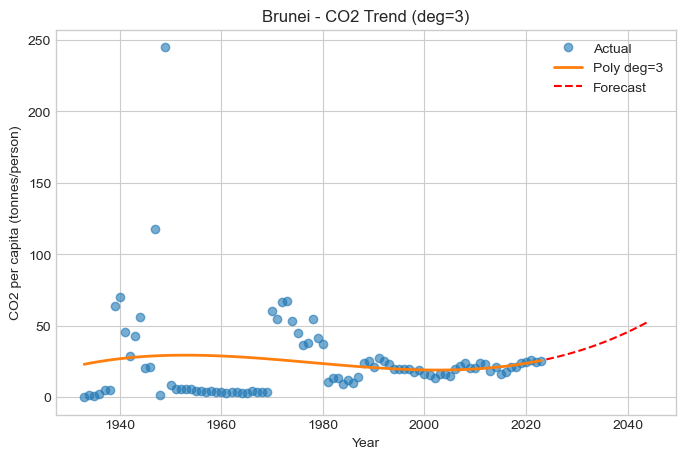

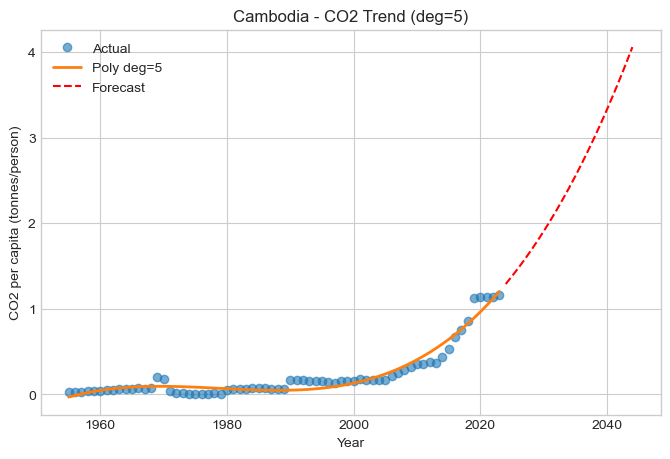

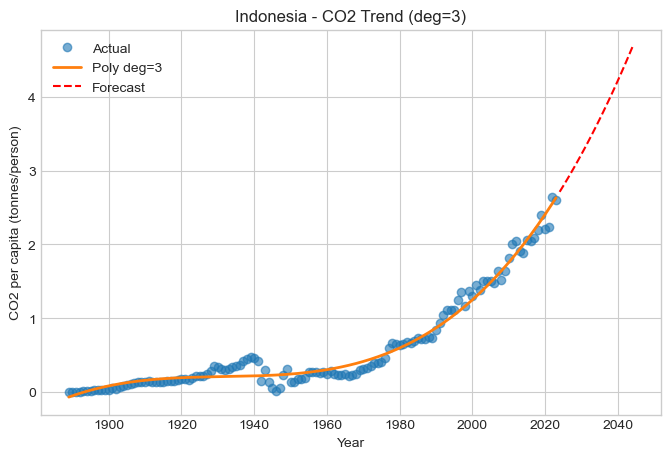

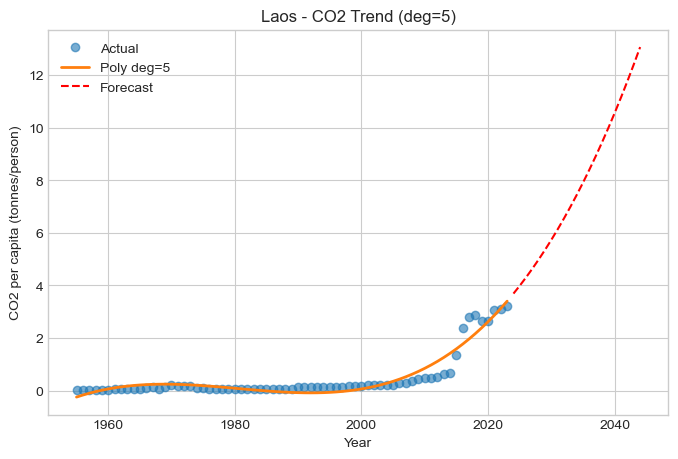

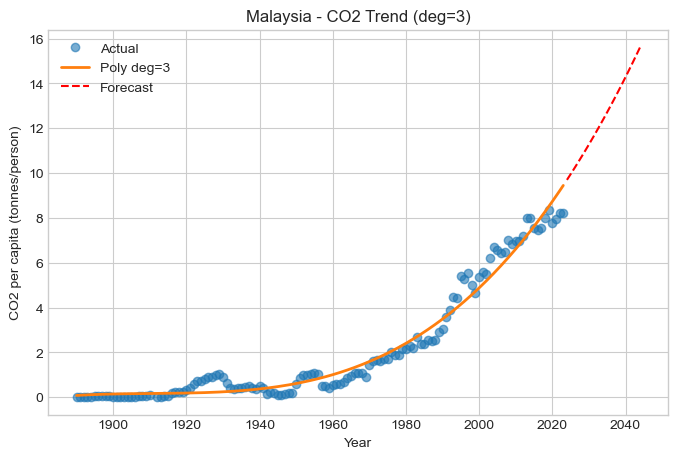

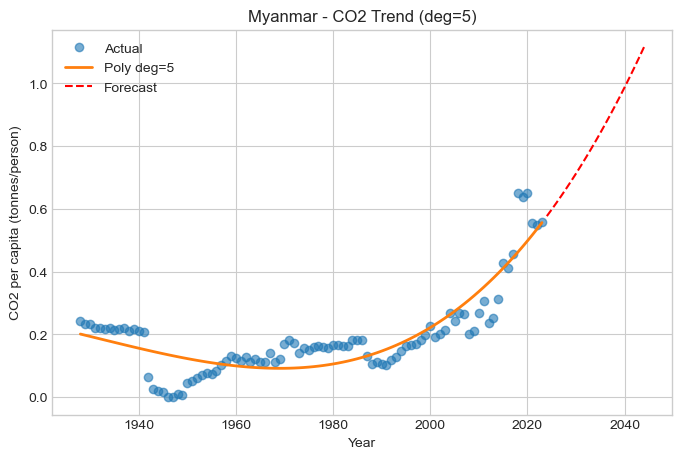

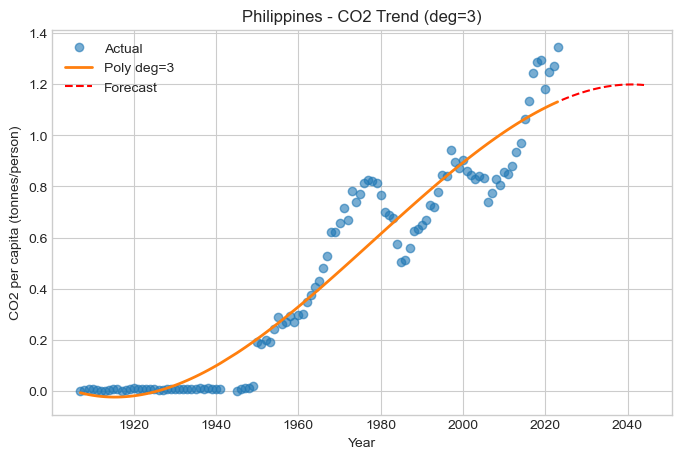

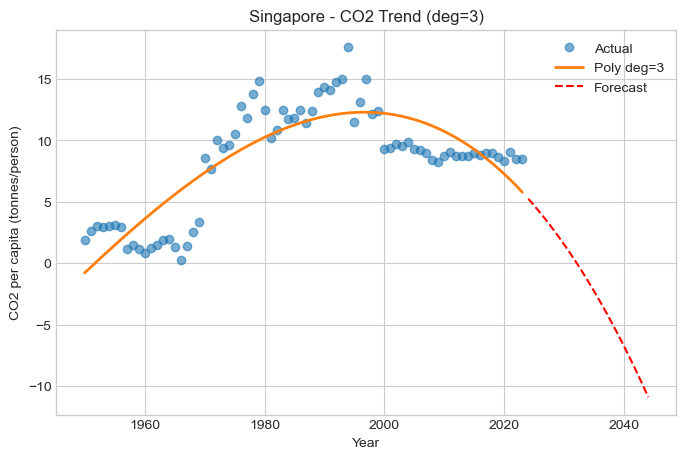

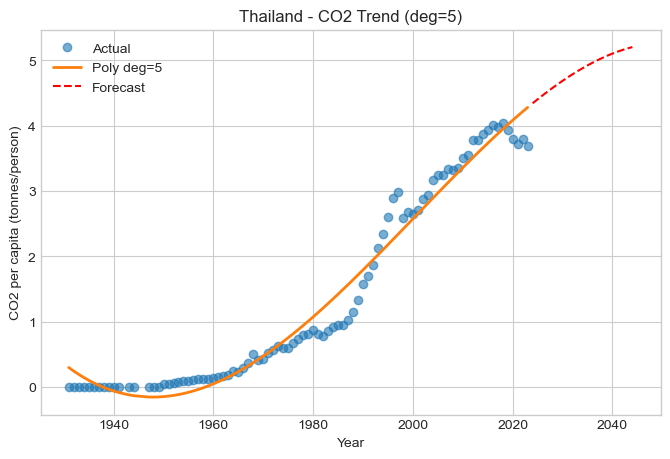

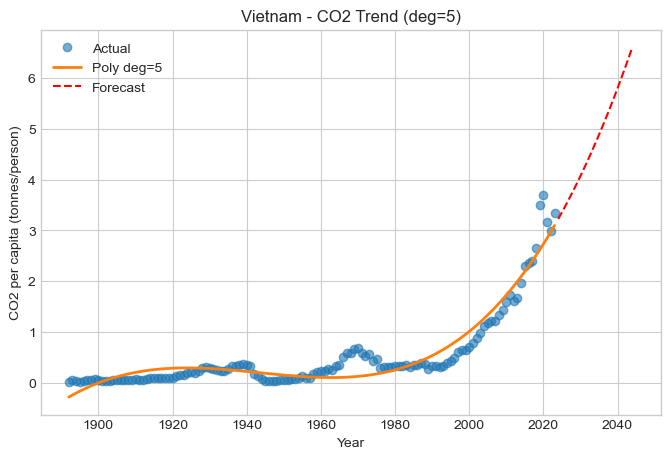

In [39]:
countries = df["country"].unique()
forecast_list = []

for country in countries:
    c_df = df[df["country"] == country].dropna(subset=["co2_per_capita"])
    X = c_df["year"].values.reshape(-1, 1)
    y = c_df["co2_per_capita"].values
    
    model, poly, best_degree, results = fit_best_polynomial(X, y, max_degree=5)
    y_pred = model.predict(poly.transform(X))
    
    future_years = np.arange(df["year"].max() + 1, 2045).reshape(-1, 1)
    future_pred = model.predict(poly.transform(future_years))
    
    temp_df = pd.DataFrame({
        "Country": country,
        "Year": future_years.flatten(),
        "Predicted_CO2_per_capita": future_pred,
        "Best_degree": best_degree
    })
    forecast_list.append(temp_df)
    
    plt.figure(figsize=(8,5))
    plt.plot(X, y, 'o', alpha=0.6, label="Actual")
    plt.plot(X, y_pred, '-', linewidth=2, label=f"Poly deg={best_degree}")
    plt.plot(future_years, future_pred, '--', color="red", label="Forecast")
    plt.title(f"{country} - CO2 Trend (deg={best_degree})")
    plt.xlabel("Year")
    plt.ylabel("CO2 per capita (tonnes/person)")
    plt.legend()
    plt.show()

forecast_all = pd.concat(forecast_list)


In [40]:
# Exporting forecast result
forecast_all.to_csv("co2_emission_forecast_auto_poly.csv", index=False)


## 5. ASEAN CO2 Emission per Capita: Historical and Forecast

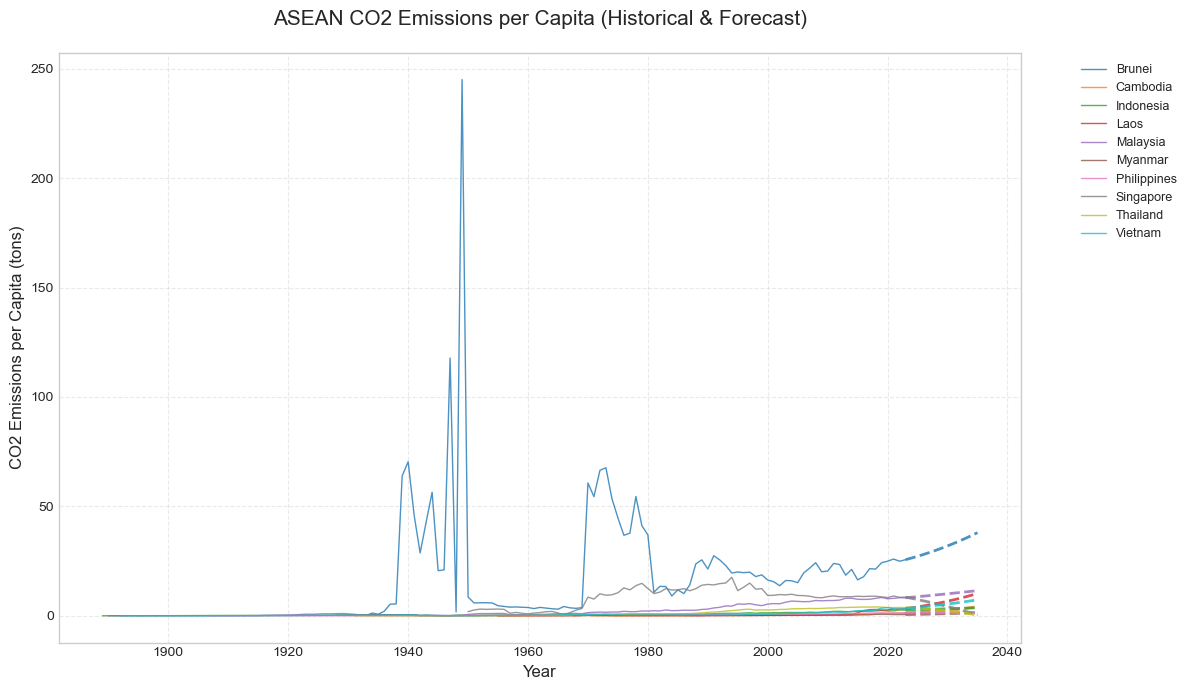

In [41]:
# Plotting the CO2 emission per capita 
plt.figure(figsize=(12, 7))

for country in df["country"].unique():
    c_df = df[df["country"] == country]
    degree = int(forecast_all[forecast_all["Country"] == country]["Best_degree"].iloc[0])

    X = c_df["year"].values
    y = c_df["co2_per_capita"].values

    poly = np.poly1d(np.polyfit(X, y, degree))

    last_year = X.max()
    last_value = y[-1]

    future_years = np.arange(last_year, 2036)
    future_pred = poly(future_years)

    offset = last_value - future_pred[0]
    future_pred = future_pred + offset
    future_pred = np.where(future_pred < 0, 0, future_pred)

    line, = plt.plot(X, y, label=f"{country}", linewidth=1, alpha=0.8)
    color = line.get_color()

    plt.plot(future_years, future_pred, linestyle="--", color=color, linewidth=2, alpha=0.8)

df["co2_per_capita"] = np.where(df["co2_per_capita"] > 20, 20, df["co2_per_capita"])

plt.title("ASEAN CO2 Emissions per Capita (Historical & Forecast)", fontsize=15, pad=20)
plt.xlabel("Year", fontsize=12)
plt.ylabel("CO2 Emissions per Capita (tons)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.4)

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=9, frameon=False)

plt.ylim(0, df["co2_per_capita"].max() * 1.1) 
plt.autoscale(enable=True, axis='y', tight=False)
plt.tight_layout()
plt.show()


## 6. Forecasting future CO₂ emissions in ASEAN with prophet forcast model

In [ ]:
selected_country = "Indonesia"  

if selected_country == "All ASEAN":
    df_filtered = (
        df.groupby("year")["co2_per_capita"]
        .mean()
        .reset_index()
    )
else:
    df_filtered = df[df["country"] == selected_country][["year", "co2_per_capita"]]


In [ ]:
# Prophet Forecast Model
from prophet import Prophet
import pandas as pd

# Prepare data
df_prophet = df_filtered[["year", "co2_per_capita"]].rename(columns={"year": "ds", "co2_per_capita": "y"})

# Prophet expects datetime for ds
df_prophet["ds"] = pd.to_datetime(df_prophet["ds"], format="%Y")

# Initialize and fit model
model = Prophet(yearly_seasonality=False, daily_seasonality=False)
model.fit(df_prophet)

# Forecast for the next 10 years
future = model.make_future_dataframe(periods=10, freq='Y')
forecast = model.predict(future)

# Merge results
forecast_result = forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]]
forecast_result["year"] = forecast_result["ds"].dt.year
forecast_result["Type"] = ["Historical" if y <= df["year"].max() else "Forecast" for y in forecast_result["year"]]


In [ ]:
# Set Parameters
selected_country = "Indonesia"   
future_year = 2035               
poly_degree = 2                  

# Build Selected DF
if selected_country == "All ASEAN Countries" or selected_country == "All ASEAN":
    # average across countries per year
    df_filtered = (
        df.groupby("year", as_index=False)["co2_per_capita"]
          .mean()
          .sort_values("year")
    )
else:
    df_filtered = df[df["country"] == selected_country][["year", "co2_per_capita"]].sort_values("year")

if df_filtered.empty:
    raise ValueError("df_filtered is empty — check your `selected_country` or df contents.")

# Fit Polynomial Regression on historical years
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd

X_hist = df_filtered["year"].values.reshape(-1, 1)
y_hist = df_filtered["co2_per_capita"].values.reshape(-1, 1)

poly = PolynomialFeatures(degree=poly_degree, include_bias=False)
X_hist_poly = poly.fit_transform(X_hist)

linreg = LinearRegression()
linreg.fit(X_hist_poly, y_hist)

# Produce predictions for full year range (historical + future)
min_year = int(df_filtered["year"].min())
max_hist_year = int(df_filtered["year"].max())
max_predict_year = int(future_year)

# make the prediction year vector 
df_forecast_years = np.arange(min_year, max_predict_year + 1)

X_all = df_forecast_years.reshape(-1, 1)
X_all_poly = poly.transform(X_all)  
y_pred = linreg.predict(X_all_poly).flatten()

# create dataframe for polynomial predictions
poly_df = pd.DataFrame({
    "year": df_forecast_years,
    "poly_prediction": y_pred
})

if 'forecast_result' not in globals():
    try:
        from prophet import Prophet
        # prepare prophet input
        df_prophet = df_filtered.rename(columns={"year":"ds", "co2_per_capita":"y"})
        df_prophet["ds"] = pd.to_datetime(df_prophet["ds"], format="%Y")
        model = Prophet(yearly_seasonality=False, daily_seasonality=False)
        model.fit(df_prophet)
        periods = max_predict_year - max_hist_year
        future = model.make_future_dataframe(periods=periods, freq='Y')
        forecast = model.predict(future)
        forecast_result = forecast[["ds","yhat","yhat_lower","yhat_upper"]].copy()
        forecast_result["year"] = forecast_result["ds"].dt.year
        forecast_result["Type"] = forecast_result["year"].apply(lambda y: "Historical" if y <= max_hist_year else "Forecast")
    except Exception as e:
        raise RuntimeError("Prophet is not available or failed. Install prophet or provide forecast_result. Error: " + str(e))

# Build compare_df by merging polynomial and prophet predictions
compare_df = poly_df.merge(
    forecast_result[["year","yhat","yhat_lower","yhat_upper","Type"]],
    on="year",
    how="outer"
).sort_values("year").reset_index(drop=True)

# Mark which years are historical in compare_df 
compare_df["is_historical"] = compare_df["year"].apply(lambda y: y <= max_hist_year)

# Attach actual historical observations for plotting
# Merge real observations to compare with predictions
obs = df_filtered.rename(columns={"co2_per_capita":"observed"})
compare_df = compare_df.merge(obs[["year","observed"]], on="year", how="left")

# Quick diagnostics
print("Historical years:", min_year, "to", max_hist_year)
print("Predicting until year:", max_predict_year)
print("Polynomial degree:", poly_degree)
print("Rows in compare_df:", len(compare_df))

compare_df.head(15)


Historical years: 1889 to 2023
Predicting until year: 2035
Polynomial degree: 2
Rows in compare_df: 148


,year,poly_prediction,yhat,yhat_lower,yhat_upper,Type,is_historical,observed
0,1889,0.296725,-0.003580,-0.106536,0.103060,Historical,True,0.000110
1,1890,0.281596,0.002674,-0.097524,0.106732,Historical,True,0.000434
2,1891,0.266915,0.008927,-0.087824,0.111466,Historical,True,0.000644
3,1892,0.252683,0.015181,-0.094383,0.125360,Historical,True,0.005523
4,1893,0.238900,0.021452,-0.084968,0.127421,Historical,True,0.011532
5,1894,0.225566,0.027705,-0.070206,0.133685,Historical,True,0.013567
6,1895,0.212681,0.033959,-0.073534,0.134296,Historical,True,0.021470
7,1896,0.200245,0.040213,-0.062204,0.150406,Historical,True,0.023742
8,1897,0.188258,0.046483,-0.064165,0.155265,Historical,True,0.030135
9,1898,0.176719,0.052737,-0.055644,0.157187,Historical,True,0.034694


In [46]:
compare_df.head()

,year,poly_prediction,yhat,yhat_lower,yhat_upper,Type,is_historical,observed
0,1889,0.296725,-0.003580,-0.106536,0.103060,Historical,True,0.000110
1,1890,0.281596,0.002674,-0.097524,0.106732,Historical,True,0.000434
2,1891,0.266915,0.008927,-0.087824,0.111466,Historical,True,0.000644
3,1892,0.252683,0.015181,-0.094383,0.125360,Historical,True,0.005523
4,1893,0.238900,0.021452,-0.084968,0.127421,Historical,True,0.011532


In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

# Historical observed data
fig.add_trace(go.Scatter(
    x=compare_df["year"],
    y=compare_df["observed"],
    mode="markers+lines",
    name="Observed Data",
    line=dict(color="black", width=2)
))

# Polynomial Regression forecast
fig.add_trace(go.Scatter(
    x=compare_df["year"],
    y=compare_df["poly_prediction"],
    mode="lines",
    name="Polynomial Regression",
    line=dict(color="blue", dash="dot")
))

# Prophet forecast (mean)
fig.add_trace(go.Scatter(
    x=compare_df["year"],
    y=compare_df["yhat"],
    mode="lines",
    name="Prophet Forecast",
    line=dict(color="red", width=2)
))

# Prophet uncertainty interval
fig.add_trace(go.Scatter(
    x=pd.concat([compare_df["year"], compare_df["year"][::-1]]),
    y=pd.concat([compare_df["yhat_upper"], compare_df["yhat_lower"][::-1]]),
    fill="toself",
    fillcolor="rgba(255, 0, 0, 0.1)",
    line=dict(color="rgba(255,255,255,0)"),
    showlegend=False,
    name="Prophet Uncertainty"
))

# Format layout
fig.update_layout(
    title=f"CO₂ Emission Forecast for {selected_country}",
    xaxis_title="Year",
    yaxis_title="CO₂ Emission per Capita (tons)",
    template="plotly_white",
    hovermode="x unified"
)

fig.show()
